In [1]:
from neuron import h, rxd
from neuron.units import ms, nM
from matplotlib import pyplot
from math import pi, exp
from copy import copy
import numpy
pyplot.ion()
h.load_file('stdrun.hoc')
h.load_file("import3d.hoc")
h.celsius = 34
h.v_init = -65
cell_counter = 0

In [2]:
class PyrNeuron:
    """Python copy of MiglioreEtAl2018PLOSCompBiol2018/cell_seed3_0-pyr-08.hoc"""
    def __init__(self, rec=False, morphology=None):
        global cell_counter
        self.name = 'pyr%i' % cell_counter
        cell_counter += 1
        self.rec = rec
        
        #import the morphology
        morph = h.Import3d_Neurolucida3()
        morph.input(morphology)
        i3d = h.Import3d_GUI(morph, 0)
        i3d.instantiate(self)
        
        #replace the axon and add the mechanisms
        self.setup()
        
        # create a geometry where volume is surface area * depth (0.1um)
        accumgeo = copy(rxd.inside)
        accumgeo.volumes1d = rxd.geometry._make_surfacearea1d_function(0.1*numpy.pi)

        self.cyt = rxd.Region(self.all, name='cyt', nrn_region='i', geometry=accumgeo)
        self.ca = rxd.Species(self.cyt, d=0, name='ca', charge=2, initial=60 * nM)

        tau = 100.0 * ms
        self.caclear = rxd.Rate(self.ca, -(self.ca - 60 * nM)/tau)
        
        if self.rec:
            self.somaV = h.Vector().record(self.soma[0](0.5)._ref_v)
            self.somaCa = h.Vector().record(self.ca.nodes(self.soma[0])._ref_concentration)

    def __repr__(self):
        return self.name


    def replace_axon(self, L_target = 60.0, nseg0 = 5):
        nseg_total = 2 * nseg0
        chunk = L_target / nseg_total
        nSec = len(self.axon)
        if nSec < 1:
            print("Less than two axon sections are present! Add an axon to the morphology and try again!")
            return
        diams = []
        lens = []
        for sec in self.axon:
            sec.nseg = 1 + int(sec.L/chunk/2.)*2
            for seg in sec:
                diams.append(seg.diam)
                lens.append(sec.L/sec.nseg)
                if len(diams) > nseg_total:
                    break
            if len(diams) > nseg_total:
                break

        # delete the old axon
        for sec in self.axon:
            h.disconnect(sec=sec)
            self.all.remove(sec)
            sref = h.SectionRef(sec=sec)
            sref.rename('delete')
            h.delete_section(sec=sec)
        
        # create the new axon
        self.axon = [h.Section(name='axon0'), h.Section(name='axon1')]

        L_real = 0
        diams.reverse()
        lens.reverse()
        for sec in self.axon:
            sec.L = L_target / 2.0
            sec.nseg = nseg_total/2
            self.all.append(sec)
            for seg in sec:
                seg.diam = diams.pop()
                L_real += lens.pop()
        self.axon[0].connect(self.soma[0])
        self.axon[1].connect(self.axon[0])
        print("Target stub axon length:", L_target, "um, equivalent length: ", L_real, "um")

    def setup(self):
        # insert the same mechanisms with the same parameters in both the soma 
        # and the dendrite
        for sec in self.all:
            sec.nseg = 1 + 2*int(sec.L/40)
        self.replace_axon()
        # python import gives a slightly different soma diam than in HOC
        for sec in self.all:
            for mechanims in ['pas', 'kdr', 'nax']:
                sec.insert(mechanims)
        h.distance(0, self.soma[0](0.5))
        for sec in self.soma:
            for mechanism in ['kmb', 'kap', 'hd', 'can', 'cal', 'cat', 'kca', 'cagk']:
                sec.insert(mechanism)
        for sec in self.apic:
            for mechanism in ['kad', 'hd', 'can', 'cal', 'cat', 'kca', 'cagk']:
                sec.insert(mechanism)
        for sec in self.axon:
            for mechanism in ['kmb', 'kap']:
                sec.insert(mechanism)
        for sec in self.dend:
            for mechanism in ['kad', 'hd', 'can', 'cal', 'cat', 'kca', 'cagk']:
                sec.insert(mechanism)
        for sec in self.all:
            for seg in sec:
                seg.cm = 1.0
                seg.ena = 50
                seg.ek = -90
        for sec in self.apic:
            for seg in sec:
                seg.kdr.gkdrbar = 0.0043036502438625682
                seg.nax.gbar = 0.038280628170345957
                seg.cal.gcalbar = 8.0324964335287e-06
                seg.can.gcanbar = 2.2618914062501833e-06
                seg.cat.gcatbar = 1.184948741542104e-06
                seg.kca.gbar = 9.0311387916396796e-05
                seg.cagk.gbar = 4.4820097108998517e-05
                seg.pas.g = 9.031387191839301e-05
                seg.hd.ghdbar = (1. + 3./100. * h.distance(seg))*1.9042409723832741e-05
                seg.pas.e = (-65.726902768520958-5*h.distance(seg)/150.0)
                seg.kad.gkabar = (15./(1. + exp((300.0-h.distance(seg))/50.0)))*0.012921529390557651
            sec.Ra = 115.3957607556371
        for sec in self.axon:
            for seg in sec:
                seg.nax.gbar = 0.21113423945477339
                seg.kdr.gkdrbar = 0.011664045469379856
                seg.kmb.gbar = 0.026473888790212396
                seg.kap.gkabar = 0.1636942175250268
                seg.pas.g = 0.00012898002027660884
                seg.pas.e = -79.917091935442244
            sec.Ra = 85.202399381150826
        for sec in self.dend:
            for seg in sec:
                seg.kdr.gkdrbar = 0.0043036502438625682
                seg.nax.gbar = 0.038280628170345957
                seg.cal.gcalbar = 8.0324964335287e-06
                seg.can.gcanbar = 2.2618914062501833e-06
                seg.cat.gcatbar = 1.184948741542104e-06
                seg.kca.gbar = 9.0311387916396796e-05
                seg.cagk.gbar = 4.4820097108998517e-05
                seg.pas.g = 9.031387191839301e-05
                seg.hd.ghdbar = (1. + 3./100. * h.distance(seg))*1.9042409723832741e-05
                seg.kad.gkabar = (15./(1. + exp((300.0-h.distance(seg))/50.0)))*0.012921529390557651
                seg.pas.e = (-65.726902768520958 - 5*h.distance(seg)/150.0)
            sec.Ra = 115.3957607556371
        for sec in self.soma:
            for seg in sec:
                seg.kap.gkabar = 0.075979013614757188
                seg.kmb.gbar = 0.0054486096208209286
                seg.kdr.gkdrbar = 0.0043036502438625682
                seg.nax.gbar = 0.038280628170345957
                seg.cal.gcalbar = 8.0324964335287e-06
                seg.can.gcanbar = 2.2618914062501833e-06
                seg.cat.gcatbar = 1.184948741542104e-06
                seg.kca.gbar = 9.0311387916396796e-05
                seg.cagk.gbar = 4.4820097108998517e-05
                seg.pas.g = 9.031387191839301e-05
                seg.hd.ghdbar = (1. + 3./100. * h.distance(seg))*1.9042409723832741e-05
                seg.pas.e = (-65.726902768520958-5.0*h.distance(seg)/150.0)
            sec.Ra = 115.3957607556371

In [3]:
cell = PyrNeuron(rec=True, morphology='mpg141209_A_idA.asc')

stim = h.IClamp(cell.soma[0](0.5))
stim.delay = 531
stim.dur = 400
stim.amp = 0.8

t_vec = h.Vector()
t_vec.record(h._ref_t)
h.finitialize(-65)



11521 lines read

mpg141209_A_idA.asc problems


Main branch starting at line 1183 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma
('Target stub axon length:', 60.0, 'um, equivalent length: ', 58.31318150492648, 'um')


1.0

In [4]:
h.continuerun(1200)

0.0

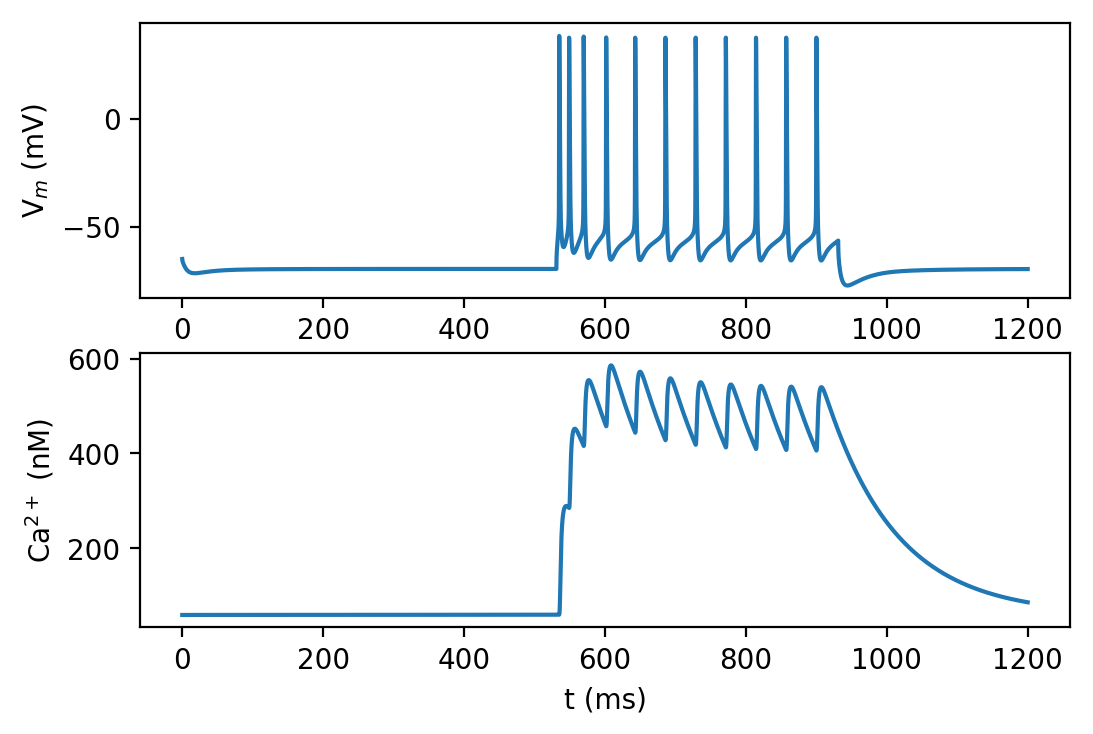

In [5]:
fig = pyplot.figure()
pyplot.subplot(2,1,1)
pyplot.plot(t_vec, cell.somaV)
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.subplot(2,1,2)
pyplot.plot(t_vec, cell.somaCa*1e6)
pyplot.xlabel('t (ms)')
pyplot.ylabel('Ca$^{2+}$ (nM)')
fig.set_dpi(200)